In [7]:
from utils.bmds import BMDSTrainer
from utils.nn import create_mlp_layers
from utils.time import timeit
import torch
from sklearn.neighbors import BallTree
from utils.preprocessing import check_tensor
from utils.distributions import exponential_log_prob
from typing import Any, Optional, Callable
from torch import nn
from abc import abstractmethod
import numpy as np
import torchvision
from tqdm import tqdm
import numpy as np
from multiprocessing import Pool
from scipy.spatial import KDTree
import os
from utils.dist import compute_pw_im
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from sklearn.model_selection import KFold
from utils.trainer import ClassifierTrainer
from utils.data import NamedDataset
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
def preprocess_dataset(dataset_name):
    filename = './data/' + dataset_name.lower() + '.npz'
    if os.path.isfile(filename):
        return np.load(filename).values()
    else:
        dataset = TUDataset(root='/tmp/' + dataset_name, name=dataset_name)
        graphs = [*map(to_networkx, dataset)]
        labels = np.array([data.y.item() for data in dataset])
        # proteins, labels = utils.read_graph_dataset(dataset_name)
        # N = len(proteins)
        
        # ipsen_mikhailov_distance = netrd.distance.IpsenMikhailov()
        # dist_mat = np.zeros((N, N), dtype=float)
        # for i, j in tqdm(combinations(range(N), 2), total=N * (N - 1) // 2):
        #     dist_mat[i, j] = dist_mat[j, i] = ipsen_mikhailov_distance(proteins[i], proteins[j])
        dist_mat = compute_pw_im(graphs)
                
        np.savez(filename, labels=labels, dist_mat=dist_mat)

        return labels, dist_mat

In [9]:
eps = 1e-10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class BaseBMDS(nn.Module):
    default_create_layers_kwargs: dict[str, Any] = {
        'activation': 'PReLU',
        'use_batch_norm': False,
        'last_layer_activation':  True,
        'last_layer_batch_norm': True,
    }

    def __init__(
        self,
        input_dim: int,
        n: int,
        *,
        n_layers: int = 2,
        hidden_dim: int = 1000,
        embedding_dim: int = 100,
        create_layers: Optional[Callable[..., list[nn.Module]]] = None,
        device: torch.device = DEVICE,
        **kwargs: Any,
    ):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n = n

        if create_layers is None:
            create_layers = create_mlp_layers
            kwargs = {**self.default_create_layers_kwargs, **kwargs}

        head_layers = create_layers(input_dim, [hidden_dim] * (n_layers - 1), hidden_dim, **kwargs)

        self.head = nn.Sequential(*head_layers).to(device)

        self.mu = nn.Parameter(torch.randn(hidden_dim, embedding_dim, device=device) / hidden_dim)
        self.sigma = nn.Parameter(torch.randn(hidden_dim, embedding_dim, device=device) / hidden_dim)

    def forward(self, inp):
        head = self.head(inp)
        return head @ self.mu, (head.pow(2) @ self.sigma.pow(2)).pow(0.5)
    
    def loss(self, batch):
        idx1, idx2, true_dist_sqr = batch.values()

        x = self.head(self.get_inp(idx1)) - self.head(self.get_inp(idx2))

        mu = x @ self.mu
        sigma = (x.pow(2) @ self.sigma.pow(2)).pow(0.5)
        
        dist_sqr = (mu + torch.randn_like(sigma) * sigma).pow(2).mean(1)
        
        log_prob = exponential_log_prob(true_dist_sqr, dist_sqr).mean()
        reg = (torch.log(self.mu.pow(2).mean(0) + self.sigma.pow(2).mean(0) + eps).sum() * self.hidden_dim - torch.log(self.sigma.pow(2) + eps).sum()) / self.n / 2
        
        return {'loss': -log_prob + reg, 'log_prob': log_prob, 'reg': reg, **self.get_metrics()}
        
    @abstractmethod
    def get_inp(self, idx):
        raise NotImplementedError

    def get_metrics(self):
        snfs = sorted((self.mu / self.sigma).pow(2).mean(0))[::-1]
        scales = sorted(self.mu.pow(2).mean(0) + self.sigma.pow(2).mean(0))[::-1]
        return {**{f"snf # {i + 1}": snfs[i] for i in range(0, 30, 5)}}


class DefaultBMDS(BaseBMDS):
    def __init__(
            self,
            dist,
            *args,
            device: torch.device = DEVICE,
            **kwargs: Any,
    ):
        super().__init__(*args, **kwargs)
        
        self.dist_sqr = check_tensor(dist, device=device).pow(2)
        
    def get_inp(self, idx):
        return self.dist_sqr[idx]

class NeighborsBMDS(BaseBMDS):
    def __init__(
            self,
            dist,
            neighbors,
            batch_size,
            *args,
            device: torch.device = DEVICE,
            **kwargs: Any,
    ):
        super().__init__(*args, **kwargs)
        
        self.dist_sqr = check_tensor(dist, device=device).pow(2)
        self.neighbors = check_tensor(neighbors, device=device)
        
        self.batch_size = batch_size
        self.obj_idx = torch.arange(batch_size, device=device).repeat(dist.shape[1], 1).T.reshape(-1)

    def get_inp(self, idx):
        neighbors_idx = self.neighbors[idx].reshape(-1)
        neighbors_dist_sqr = self.dist_sqr[idx].reshape(-1)
        
        return torch.sparse_coo_tensor(
            indices=torch.stack((self.obj_idx, neighbors_idx)),
            values=neighbors_dist_sqr,
            size=(self.batch_size, self.input_dim),
        )


class RandomObjectsBMDS(BaseBMDS):
    def __init__(self, dist, *args, device: torch.device = DEVICE, **kwargs):
        super().__init__(*args, **kwargs)

        self.dist = check_tensor(dist, device=device)
    
    def get_inp(self, idx):
        return self.dist[idx]
    
    
class NeighborsDataset(torch.utils.data.Dataset):
    def __init__(self, dist, neighbors):
        super().__init__()
        
        self.object_idx = torch.arange(dist.shape[0]).repeat(dist.shape[1], 1).T.reshape(-1)
        self.neighbors_idx = check_tensor(neighbors, dtype=torch.int64).reshape(-1)
        self.dist_sqr = (check_tensor(dist).reshape(-1) / dist.max()).pow(2)
        
    def __len__(self):
        return self.dist_sqr.shape[0]
    
    def __getitem__(self, idx):
        return {'idx1': self.object_idx[idx], 'idx2': self.neighbors_idx[idx], 'dist_sqr': self.dist_sqr[idx]}
    
    
def create_generator(dataset: torch.utils.data.Dataset, batch_size: int = 128, shuffle: bool = True, drop_last: bool = True, **kwargs):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, **kwargs)
    while True:
        yield from loader

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: antonii-belyshev. Use `wandb login --relogin` to force relogin


100%|██████████| 20000/20000 [14:40<00:00, 22.71it/s]


log_prob/train,▁▇▅▃▁▆▁█▃▅▃▅▆█▆█▃▄▅▆▅▅▇▅█▆▆█▆▆▅▃▆▃▅▇▅█▅▅
loss/train,█▃▄▆▇▃▇▁▅▄▅▄▂▁▃▁▅▅▄▃▄▄▂▄▁▂▃▁▃▂▄▅▂▅▄▂▄▁▄▄
reg/train,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 1/train,▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁█▁▁▁▁▁▁▁▂▁▁
snf # 11/train,▁▁▁▂▁▁▁▃▃▃▃▄▅▄▄▄▃▄▃▅▇█▄▄▃▇▅▄▄▄▄▅▆▇▃▅▂▄▃▆
snf # 16/train,▄▃▃▂▂▂▁▂▂▁▁▁▁▂▅▄▄▅▆▄█▃▅▇▃▆▅▅▄▄▃▆▆▅▅▃▃▄▅▅
snf # 21/train,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 26/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 6/train,▁▁▁▂▂▂▃▄▂▂▆▄▇▃▄▄▄▃▇▄▅▆▃▆▄▄▄▃▄▄▅▅▇█▄▃▃▅▄▆
log_prob/train,-0.05827
loss/train,0.05921


number components: tensor(16, device='cuda:0')


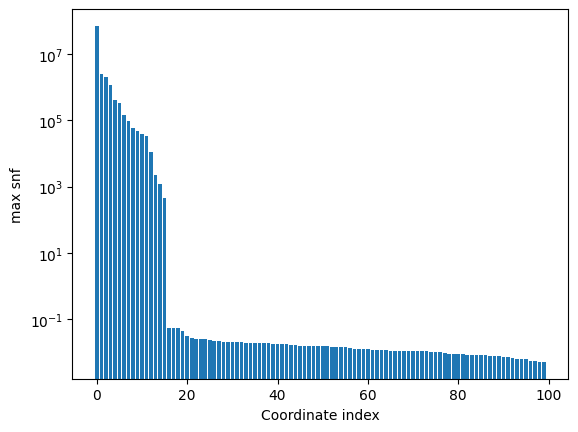

100%|██████████| 10000/10000 [00:52<00:00, 190.64it/s]


loss/train,█▇▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.01001


train accuracy: 0.999000999000999
eval_accuracy: 0.9732142857142857


100%|██████████| 10000/10000 [00:50<00:00, 197.81it/s]


loss/train,██▅▄▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.01269


train accuracy: 0.999000999000999
eval_accuracy: 0.9821428571428571


100%|██████████| 10000/10000 [00:52<00:00, 190.22it/s]


loss/train,██▅▄▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.007


train accuracy: 1.0
eval_accuracy: 0.9642857142857143


100%|██████████| 10000/10000 [00:49<00:00, 200.62it/s]


loss/train,█▆▅▄▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.00813


train accuracy: 0.999001996007984
eval_accuracy: 0.990990990990991


100%|██████████| 10000/10000 [00:52<00:00, 188.80it/s]


loss/train,█▇▅▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.00231


train accuracy: 0.999001996007984
eval_accuracy: 0.972972972972973


100%|██████████| 10000/10000 [00:52<00:00, 192.02it/s]


loss/train,██▅▄▃▃▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.00378


train accuracy: 0.999001996007984
eval_accuracy: 0.9819819819819819


100%|██████████| 10000/10000 [00:53<00:00, 186.20it/s]


loss/train,█▇▅▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.00486


train accuracy: 0.999001996007984
eval_accuracy: 0.9819819819819819


100%|██████████| 10000/10000 [00:49<00:00, 200.95it/s]


loss/train,█▆▅▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.00356


train accuracy: 0.999001996007984
eval_accuracy: 0.963963963963964


100%|██████████| 10000/10000 [01:00<00:00, 165.80it/s]


loss/train,█▇▅▄▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.00212


train accuracy: 1.0
eval_accuracy: 0.9459459459459459


100%|██████████| 10000/10000 [00:53<00:00, 188.12it/s]


loss/train,█▆▅▃▃▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.00963


train accuracy: 1.0
eval_accuracy: 0.963963963963964


,train accuracy,evaluation accuracy
mean,0.999301,0.972144
std,0.000482,0.013049


In [4]:
dataset_name = 'PROTEINS'

labels, dist_mat = preprocess_dataset(dataset_name)

dataset = NeighborsDataset(dist_mat, torch.arange(len(dist_mat)).repeat(len(dist_mat), 1))
bmds = DefaultBMDS(dist_mat, len(dist_mat), len(dataset), hidden_dim=200)
bmds_trainer = BMDSTrainer(bmds, lr=2e-2)

bmds_trainer.train(create_generator(dataset, batch_size=1000), project_name=dataset_name + ' bmds', experiment_name='full data', total_iters=20000)

snf_mask = ((bmds.mu / bmds.sigma).pow(2) > 100).any(0)
print('number components:', snf_mask.sum())

plt.figure()
plt.bar(range(100), sorted((bmds.mu / bmds.sigma).pow(2).max(0)[0].detach().cpu(), reverse=True))
plt.yscale('log')
plt.xlabel('Coordinate index')
plt.ylabel('max snf')
plt.show()

embedding = bmds(check_tensor(dist_mat, device=DEVICE).pow(2))[0][:, snf_mask].detach().cpu()

train_accs = []
eval_accs = []
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (idx_train, idx_eval) in enumerate(k_fold.split(embedding, labels)):
    embedding_train, embedding_eval, labels_train, labels_eval = embedding[idx_train], embedding[idx_eval], labels[idx_train], labels[idx_eval]
    
    clf = torch.nn.Sequential(*create_mlp_layers(embedding_train.shape[1], [100], 2))
    clf_trainer = ClassifierTrainer(clf)
    clf_trainer.train(create_generator(NamedDataset(['x', 'y'], [embedding_train, labels_train])), project_name=dataset_name + ' clf', experiment_name='fold' + str(i), total_iters=10000)

    train_acc = (clf(embedding_train.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_train).mean()
    eval_acc = (clf(embedding_eval.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_eval).mean()

    print('train accuracy:', train_acc)
    print('eval_accuracy:', eval_acc)

    train_accs.append(train_acc)
    eval_accs.append(eval_acc)

df = pd.DataFrame({'train accuracy': train_accs, 'evaluation accuracy': eval_accs})
pd.DataFrame({'mean': df.mean(), 'std': df.std()}).T

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


log_prob/train,▁▄▃▇▄▆▄▇▃▂▄▇▂▆▄█▄▅▆▃▆▇▆▆▅▃▄▅▅▇▅▅▅▅▆▄▆▆▇▃
loss/train,█▅▆▂▅▃▅▂▆▆▄▂▇▃▄▁▄▄▂▆▃▂▂▃▄▅▄▄▄▂▄▄▃▄▃▅▃▃▁▅
reg/train,██▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 1/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
snf # 11/train,▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▂▂▃▃▂█▃▄▃▄▂▃▆▃▃▄▅▄▇▅
snf # 16/train,█▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 21/train,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 26/train,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 6/train,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▃▄▄▇▆▃▃▄▅▄▃▆▃▄▅▄▅▅█▆▅▅▇▅
log_prob/train,-0.10945
loss/train,0.11043


100%|██████████| 20000/20000 [18:44<00:00, 17.78it/s]


log_prob/train,▁▃▆▇▅▅▇▇▇██▆▄█▆██▇██▆█████▆▆████▆██████▆
loss/train,█▆▄▃▄▄▂▂▂▂▁▃▅▁▃▁▁▂▁▁▃▁▁▁▁▁▃▃▁▁▁▁▃▁▁▁▁▁▁▃
reg/train,▅▆▇███▇▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 1/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂█▂▁▁▁▂▁▄▁▁▃▁▁
snf # 11/train,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▄▃▃▄▄▄█▆▄▆▆▅▆▆▆▅▆▅▅█▇█▆▆
snf # 16/train,▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▄▄▅▅▄▅▅▆▆▅▇▇█▇▅
snf # 21/train,▅▇▇██▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 26/train,▆▇███▇▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 6/train,▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▆▆▅▇▅▇▆▆▅▇█▆▆▇▆█▅▇
log_prob/train,-0.00513
loss/train,0.00566


number components: tensor(18, device='cuda:0')


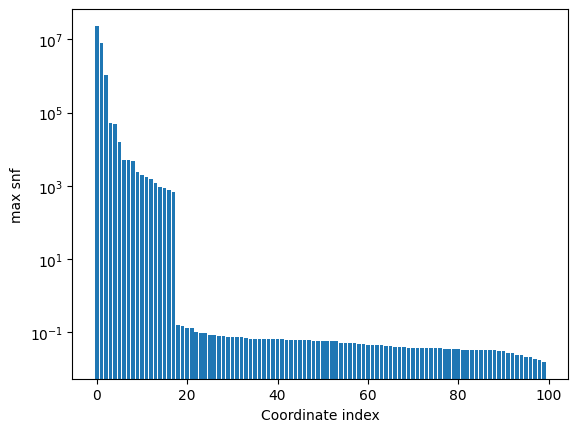

100%|██████████| 10000/10000 [01:05<00:00, 152.66it/s]


loss/train,█▆▄▂▂▂▁▂▁▁▃▁▁▁▄▁▁▁▁▃▄▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁
loss/train,0.00181


train accuracy: 1.0
eval_accuracy: 0.9635036496350365


100%|██████████| 10000/10000 [01:13<00:00, 136.67it/s]


loss/train,▆▄▄▆▂▂▂▂▁▁▂▁▂▂█▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.01164


train accuracy: 1.0
eval_accuracy: 0.9440389294403893


100%|██████████| 10000/10000 [01:06<00:00, 149.48it/s]


loss/train,█▆▄▃▁▁▂▂▂▃▁▂▂▁▁▁▁▃▃▂▂▁▂▁▁▂▄▁▁▁▁▄▁▁▃▁▁▁▃▁
loss/train,0.00067


train accuracy: 1.0
eval_accuracy: 0.9245742092457421


100%|██████████| 10000/10000 [01:05<00:00, 152.92it/s]


loss/train,█▅▄▃▃▂▂▂▁▁▂▁▂▁▁▃▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.00014


train accuracy: 1.0
eval_accuracy: 0.9318734793187348


100%|██████████| 10000/10000 [01:05<00:00, 153.28it/s]


loss/train,█▅▃▂▂▁▂▂▁▁▁▂▃▂▂▁▁▁▁▁▂▁▁▁▃▂▁▁▁▁▂▁▁▁▁▁▂▁▃▁
loss/train,0.00097


train accuracy: 1.0
eval_accuracy: 0.9513381995133819


100%|██████████| 10000/10000 [01:12<00:00, 137.46it/s]


loss/train,█▃▄▃▃▂▂▄▁▃▁▃▁▃▂▁▂▂▁▂▁▂▁▂▂▁▂▁▁▁▂▁▂▁▇▁▁▂▁▁
loss/train,0.07863


train accuracy: 1.0
eval_accuracy: 0.9440389294403893


100%|██████████| 10000/10000 [01:05<00:00, 151.91it/s]


loss/train,▇█▂▂▃▁▄▂▁▁▂▁▁▁▁▂▂▁▁▂▂▁▁▄▁▁▁▂▁▁▁▃▃▁▁▁▂▁▂▁
loss/train,0.00033


train accuracy: 1.0
eval_accuracy: 0.9294403892944039


100%|██████████| 10000/10000 [01:06<00:00, 150.54it/s]


loss/train,█▅▃▄▅▁▂▂▁▂▁▁▁▂▁▂▁▁▁▁▂▄▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁▃▁▁
loss/train,0.00039


train accuracy: 1.0
eval_accuracy: 0.9562043795620438


100%|██████████| 10000/10000 [01:13<00:00, 136.25it/s]


loss/train,▆▄▄▂▅▁█▁▁▁▂▂▁▃▁▁▂▁▁▂▁▁▂▂▃▁▁▂▂▁▄▂▁▁▁▁▃▁▁▁
loss/train,0.03083


train accuracy: 0.9981075966477426
eval_accuracy: 0.9367396593673966


100%|██████████| 10000/10000 [01:06<00:00, 149.49it/s]


loss/train,▇▇▅▂▂▂▂▅▂▂█▁▁▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▂▇
loss/train,0.00829


train accuracy: 1.0
eval_accuracy: 0.9416058394160584


,train accuracy,evaluation accuracy
mean,0.999811,0.942336
std,0.000598,0.012249


In [10]:
dataset_name = 'NCI1'

labels, dist_mat = preprocess_dataset(dataset_name)

dataset = NeighborsDataset(dist_mat, torch.arange(len(dist_mat)).repeat(len(dist_mat), 1))
bmds = DefaultBMDS(dist_mat, len(dist_mat), len(dataset))
bmds_trainer = BMDSTrainer(bmds, lr=1e-3)

bmds_trainer.train(create_generator(dataset, batch_size=1000), project_name=dataset_name + ' bmds', experiment_name='full data', total_iters=20000)

snf_mask = ((bmds.mu / bmds.sigma).pow(2) > 100).any(0)
print('number components:', snf_mask.sum())

plt.figure()
plt.bar(range(100), sorted((bmds.mu / bmds.sigma).pow(2).max(0)[0].detach().cpu(), reverse=True))
plt.yscale('log')
plt.xlabel('Coordinate index')
plt.ylabel('max snf')
plt.show()

embedding = bmds(check_tensor(dist_mat, device=DEVICE).pow(2))[0][:, snf_mask].detach().cpu()

train_accs = []
eval_accs = []
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (idx_train, idx_eval) in enumerate(k_fold.split(embedding, labels)):
    embedding_train, embedding_eval, labels_train, labels_eval = embedding[idx_train], embedding[idx_eval], labels[idx_train], labels[idx_eval]
    
    clf = torch.nn.Sequential(*create_mlp_layers(embedding_train.shape[1], [100, 100, 100], 2))
    clf_trainer = ClassifierTrainer(clf, lr=1e-2)
    clf_trainer.train(create_generator(NamedDataset(['x', 'y'], [embedding_train, labels_train])), project_name=dataset_name + ' clf', experiment_name='fold' + str(i), total_iters=10000)

    train_acc = (clf(embedding_train.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_train).mean()
    eval_acc = (clf(embedding_eval.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_eval).mean()

    print('train accuracy:', train_acc)
    print('eval_accuracy:', eval_acc)

    train_accs.append(train_acc)
    eval_accs.append(eval_acc)

df = pd.DataFrame({'train accuracy': train_accs, 'evaluation accuracy': eval_accs})
pd.DataFrame({'mean': df.mean(), 'std': df.std()}).T

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [15:05<00:00, 22.10it/s]


log_prob/train,▄▅▃▄▄▅▅▅▅▅▂▆▃▄▃▂▄▆▄▆▇▆▃▅▇▄▃▄▃▃▇▁▆▇█▂▅▄▆▃
loss/train,▅▅▆▅▅▄▄▄▄▄▇▃▆▅▆▇▅▃▅▃▂▃▆▄▂▅▆▅▆▆▂█▃▂▁▇▄▅▃▆
reg/train,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 1/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 11/train,▂▁▁▁▂▂▁▁▁▂▁▃▄▄▅▃▅▅▄▆▅▆▅▆▃▄▅▅▅▄▇▅▄▅▆▅█▇▅█
snf # 16/train,█▄▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 21/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 26/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 6/train,▁▁▁▂▂▃▄▅▃▅▆▆▃▃▅▅▅▇▆▅▅▄▄▅▆▅▆▅▄▄█▅▆▄▆▆▅▆▅█
log_prob/train,-0.17775
loss/train,0.17865


number components: tensor(13, device='cuda:0')


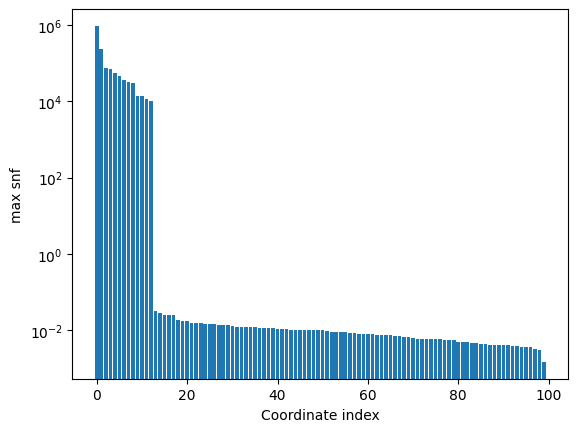

100%|██████████| 10000/10000 [01:02<00:00, 159.48it/s]


loss/train,█▇▆▅▄▄▄▃▄▃▂▂▂▂▃▂▂▂▂▁▂▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.05523


train accuracy: 0.9888888888888889
eval_accuracy: 0.96


100%|██████████| 10000/10000 [01:00<00:00, 164.16it/s]


loss/train,██▆▆▆▄▄▃▃▃▃▂▃▃▂▂▃▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂
loss/train,0.05998


train accuracy: 0.99
eval_accuracy: 0.97


100%|██████████| 10000/10000 [00:54<00:00, 183.32it/s]


loss/train,█▆▇▆▄▄▄▄▃▃▃▂▃▂▃▂▂▃▂▁▂▁▁▂▃▂▂▂▂▃▂▁▂▂▁▁▁▁▁▂
loss/train,0.06498


train accuracy: 0.9888888888888889
eval_accuracy: 0.97


100%|██████████| 10000/10000 [00:54<00:00, 183.26it/s]


loss/train,█▇▆▆▅▄▄▄▄▃▄▂▃▃▂▂▂▃▂▃▂▂▂▂▂▁▁▂▂▁▁▁▂▂▁▁▁▁▁▁
loss/train,0.0295


train accuracy: 0.9922222222222222
eval_accuracy: 0.95


100%|██████████| 10000/10000 [00:55<00:00, 181.18it/s]


loss/train,█▇▆▅▄▄▄▃▃▃▃▃▂▃▂▂▃▂▂▂▂▂▁▁▂▁▁▂▂▂▂▂▁▁▂▁▁▁▁▁
loss/train,0.05148


train accuracy: 0.9911111111111112
eval_accuracy: 0.94


100%|██████████| 10000/10000 [00:50<00:00, 197.99it/s]


loss/train,██▇▇▆▄▄▄▃▃▃▂▃▃▃▃▄▂▃▂▂▂▂▁▂▂▂▃▁▁▂▂▁▂▁▁▁▁▂▂
loss/train,0.03965


train accuracy: 0.9877777777777778
eval_accuracy: 0.96


100%|██████████| 10000/10000 [00:54<00:00, 184.07it/s]


loss/train,█▇▆▅▅▄▄▃▃▃▂▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▂▁▁▁▁
loss/train,0.0494


train accuracy: 0.9866666666666667
eval_accuracy: 0.93


100%|██████████| 10000/10000 [00:54<00:00, 185.11it/s]


loss/train,█▆▆▄▄▄▄▄▃▃▂▃▂▃▃▂▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁
loss/train,0.03951


train accuracy: 0.9877777777777778
eval_accuracy: 0.96


100%|██████████| 10000/10000 [01:02<00:00, 159.02it/s]


loss/train,██▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▃▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▂▂▁▁
loss/train,0.05688


train accuracy: 0.9877777777777778
eval_accuracy: 0.97


100%|██████████| 10000/10000 [00:51<00:00, 194.19it/s]


loss/train,▇█▆▆▅▄▃▃▃▃▂▂▂▃▂▂▃▂▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
loss/train,0.04269


train accuracy: 0.9877777777777778
eval_accuracy: 0.94


,train accuracy,evaluation accuracy
mean,0.988889,0.955000
std,0.001737,0.014337


In [11]:
dataset_name = 'IMDB-BINARY'

labels, dist_mat = preprocess_dataset(dataset_name)

dataset = NeighborsDataset(dist_mat, torch.arange(len(dist_mat)).repeat(len(dist_mat), 1))
bmds = DefaultBMDS(dist_mat, len(dist_mat), len(dataset), hidden_dim=200)
bmds_trainer = BMDSTrainer(bmds, lr=2e-2)

bmds_trainer.train(create_generator(dataset, batch_size=1000), project_name=dataset_name + ' bmds', experiment_name='full data', total_iters=20000)

snf_mask = ((bmds.mu / bmds.sigma).pow(2) > 100).any(0)
print('number components:', snf_mask.sum())

plt.figure()
plt.bar(range(100), sorted((bmds.mu / bmds.sigma).pow(2).max(0)[0].detach().cpu(), reverse=True))
plt.yscale('log')
plt.xlabel('Coordinate index')
plt.ylabel('max snf')
plt.show()

embedding = bmds(check_tensor(dist_mat, device=DEVICE).pow(2))[0][:, snf_mask].detach().cpu()

train_accs = []
eval_accs = []
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (idx_train, idx_eval) in enumerate(k_fold.split(embedding, labels)):
    embedding_train, embedding_eval, labels_train, labels_eval = embedding[idx_train], embedding[idx_eval], labels[idx_train], labels[idx_eval]
    
    clf = torch.nn.Sequential(*create_mlp_layers(embedding_train.shape[1], [100], 2))
    clf_trainer = ClassifierTrainer(clf)
    clf_trainer.train(create_generator(NamedDataset(['x', 'y'], [embedding_train, labels_train])), project_name=dataset_name + ' clf', experiment_name='fold' + str(i), total_iters=10000)

    train_acc = (clf(embedding_train.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_train).mean()
    eval_acc = (clf(embedding_eval.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_eval).mean()

    print('train accuracy:', train_acc)
    print('eval_accuracy:', eval_acc)

    train_accs.append(train_acc)
    eval_accs.append(eval_acc)

df = pd.DataFrame({'train accuracy': train_accs, 'evaluation accuracy': eval_accs})
pd.DataFrame({'mean': df.mean(), 'std': df.std()}).T

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [15:08<00:00, 22.02it/s]


log_prob/train,▆▃▆▄▇▅▇▇▇▇▃▇████▆█▁█▅▃██▅█▅▆▆█▅█████▅▆█▆
loss/train,▅▇▄▅▂▄▂▂▂▂▆▂▁▁▁▁▃▁█▁▄▆▁▁▄▁▃▃▃▁▄▁▁▁▁▁▃▃▁▃
reg/train,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 1/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
snf # 11/train,█▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 21/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 26/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 6/train,▁▁▁▁▁▁▂▃▃▅▂▃▃▂▂▂▂▄▃▃▃▃▄▃▅▃▄▄▄▃▃▄▄▄▃▄▃█▃▃
log_prob/train,-0.02972
loss/train,0.03038


number components: tensor(10, device='cuda:0')


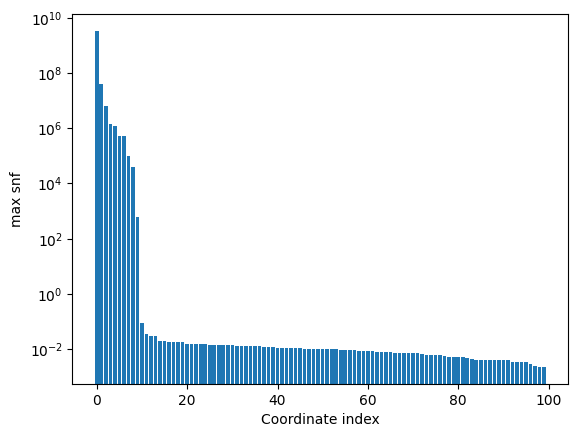

100%|██████████| 10000/10000 [00:54<00:00, 183.16it/s]


loss/train,██▇▆▆▅▅▄▄▃▃▃▃▃▃▂▃▃▂▂▂▃▂▂▃▂▂▂▂▁▂▁▃▂▂▁▁▁▁▁
loss/train,0.11468


train accuracy: 0.970754716981132
eval_accuracy: 0.9576271186440678


100%|██████████| 10000/10000 [00:54<00:00, 184.72it/s]


loss/train,█▇▆▆▅▃▄▃▄▃▃▃▃▂▃▃▃▂▂▂▁▂▁▂▂▂▁▂▂▃▂▂▁▁▂▁▁▁▂▁
loss/train,0.07908


train accuracy: 0.970754716981132
eval_accuracy: 0.9491525423728814


100%|██████████| 10000/10000 [01:01<00:00, 163.00it/s]


loss/train,███▇▅▄▅▄▅▄▂▃▃▃▂▃▂▂▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▃▁
loss/train,0.10213


train accuracy: 0.9754716981132076
eval_accuracy: 0.9491525423728814


100%|██████████| 10000/10000 [01:00<00:00, 164.88it/s]


loss/train,██▇▅▅▄▅▄▄▄▂▄▂▃▃▃▂▃▃▂▂▂▂▂▂▂▃▂▂▂▁▁▂▂▂▂▂▁▁▁
loss/train,0.06802


train accuracy: 0.9745283018867924
eval_accuracy: 0.923728813559322


100%|██████████| 10000/10000 [00:53<00:00, 186.12it/s]


loss/train,▇█▆▆▆▄▄▄▃▃▃▃▃▂▂▄▂▂▂▂▁▂▂▂▁▂▂▂▁▂▂▂▂▁▂▂▂▁▁▂
loss/train,0.10194


train accuracy: 0.980188679245283
eval_accuracy: 0.9915254237288136


100%|██████████| 10000/10000 [00:54<00:00, 183.73it/s]


loss/train,█▆▇▅▄▄▅▅▃▄▃▃▃▄▃▃▂▂▃▃▂▂▂▃▂▂▂▂▁▂▁▁▃▁▂▁▂▂▁▁
loss/train,0.07734


train accuracy: 0.9726415094339622
eval_accuracy: 0.9322033898305084


100%|██████████| 10000/10000 [00:51<00:00, 194.90it/s]


loss/train,█▇▆▆▄▄▄▄▃▄▃▃▃▂▃▂▃▃▂▂▂▂▂▂▃▁▃▂▂▂▂▂▁▂▂▁▂▂▁▂
loss/train,0.05107


train accuracy: 0.9688679245283018
eval_accuracy: 0.923728813559322


100%|██████████| 10000/10000 [00:54<00:00, 182.61it/s]


loss/train,██▆▆▅▃▄▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▁▂▁▂▁▂▁▁▂
loss/train,0.08513


train accuracy: 0.970754716981132
eval_accuracy: 0.9661016949152542


100%|██████████| 10000/10000 [00:51<00:00, 195.22it/s]


loss/train,██▆▆▅▅▄▃▄▃▃▃▂▃▃▃▂▂▂▃▂▂▂▂▂▃▂▁▂▂▁▂▂▂▁▁▁▂▂▁
loss/train,0.06024


train accuracy: 0.9641847313854854
eval_accuracy: 0.9145299145299145


100%|██████████| 10000/10000 [00:51<00:00, 192.92it/s]


loss/train,██▇▆▆▄▅▄▃▃▃▃▃▂▃▃▂▃▃▃▂▂▂▂▁▁▁▂▂▂▁▁▂▂▂▁▁▂▁▁
loss/train,0.05766


train accuracy: 0.9745523091423186
eval_accuracy: 0.9401709401709402


,train accuracy,evaluation accuracy
mean,0.972270,0.944792
std,0.004311,0.023151


In [12]:
dataset_name = 'DD'

labels, dist_mat = preprocess_dataset(dataset_name)

dataset = NeighborsDataset(dist_mat, torch.arange(len(dist_mat)).repeat(len(dist_mat), 1))
bmds = DefaultBMDS(dist_mat, len(dist_mat), len(dataset), hidden_dim=200)
bmds_trainer = BMDSTrainer(bmds, lr=2e-2)

bmds_trainer.train(create_generator(dataset, batch_size=1000), project_name=dataset_name + ' bmds', experiment_name='full data', total_iters=20000)

snf_mask = ((bmds.mu / bmds.sigma).pow(2) > 100).any(0)
print('number components:', snf_mask.sum())

plt.figure()
plt.bar(range(100), sorted((bmds.mu / bmds.sigma).pow(2).max(0)[0].detach().cpu(), reverse=True))
plt.yscale('log')
plt.xlabel('Coordinate index')
plt.ylabel('max snf')
plt.show()

embedding = bmds(check_tensor(dist_mat, device=DEVICE).pow(2))[0][:, snf_mask].detach().cpu()

train_accs = []
eval_accs = []
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (idx_train, idx_eval) in enumerate(k_fold.split(embedding, labels)):
    embedding_train, embedding_eval, labels_train, labels_eval = embedding[idx_train], embedding[idx_eval], labels[idx_train], labels[idx_eval]
    
    clf = torch.nn.Sequential(*create_mlp_layers(embedding_train.shape[1], [100], 2))
    clf_trainer = ClassifierTrainer(clf)
    clf_trainer.train(create_generator(NamedDataset(['x', 'y'], [embedding_train, labels_train])), project_name=dataset_name + ' clf', experiment_name='fold' + str(i), total_iters=10000)

    train_acc = (clf(embedding_train.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_train).mean()
    eval_acc = (clf(embedding_eval.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_eval).mean()

    print('train accuracy:', train_acc)
    print('eval_accuracy:', eval_acc)

    train_accs.append(train_acc)
    eval_accs.append(eval_acc)

df = pd.DataFrame({'train accuracy': train_accs, 'evaluation accuracy': eval_accs})
pd.DataFrame({'mean': df.mean(), 'std': df.std()}).T